##### [sample solution, trained for a few hours (not converged)]

# This tutorial is will bring you through your first deep reinforcement learning model


* Seaquest game as an example
* Training a simple lasagne neural network for Q_learning objective


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


In [1]:
%load_ext autoreload
%autoreload 2

# Experiment setup
* Here we basically just load the game and check that it works

In [2]:
from __future__ import print_function 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS="floatX=float32"

env: THEANO_FLAGS="floatX=float32"


In [3]:
#global params.
GAME = "LunarLanderContinuous-v2"

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
env = gym.make(GAME)
env.reset()
obs = env.step(env.action_space.sample())[0]
state_size = len(obs)
print(obs.shape)

[2016-12-20 02:41:41,395] Making new env: LunarLanderContinuous-v2


(8,)


In [5]:
env.action_space.low,env.action_space.high,

(array([-1., -1.]), array([ 1.,  1.]))

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using shallow neural network.


In [6]:
import lasagne
from lasagne.layers import InputLayer,DenseLayer,batch_norm,dropout,NonlinearityLayer,GaussianNoiseLayer,ElemwiseSumLayer
import theano.tensor as T
#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,state_size))

dense0 = DenseLayer(observation_layer,256,name='dense1')
dense1 = DenseLayer(dense0,256,name='dense2',nonlinearity=T.tanh,)

nn = dense1

In [7]:
#a layer that predicts Qvalues
from agentnet.learning.qlearning_naf import LowerTriangularLayer,NAFLayer
import theano
epsilon = theano.shared(np.float32(0.0))
n_actions = env.action_space.shape[0]
low = env.action_space.low
high = env.action_space.high

class naf:
    #predict mean
    mean = DenseLayer(nn,n_actions,nonlinearity=None,name='mu')
    
    action = NonlinearityLayer(mean,lambda a: a.clip(low,high))
    #add exploration (noize)
    action = GaussianNoiseLayer(action,sigma=epsilon)
    #clip back to action range
    action = NonlinearityLayer(action,lambda a: a.clip(low,high))
    
    #state value (for optimal action)
    V_layer = DenseLayer(nn,1,nonlinearity=None,name='V')
    
    #lower triangular matrix that describes "variance" term in NAF
    L_layer = LowerTriangularLayer(nn,n_actions,name='L')
    
    #advantage term [negative]
    A_layer = NAFLayer(action,mean,L_layer)
    
    #Q = V + A = optimal_value + negative_penalty_for_diverging_from_mean
    qvalues_layer = ElemwiseSumLayer([V_layer,A_layer])
    
    

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [8]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=[naf.qvalues_layer,naf.V_layer,naf.L_layer,naf.mean],
              action_layers=naf.action)


In [9]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(naf.qvalues_layer,trainable=True)
weights

[dense1.W,
 dense1.b,
 dense2.W,
 dense2.b,
 V.W,
 V.b,
 mu.W,
 mu.b,
 L.preprocess_input.W,
 L.preprocess_input.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [10]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,GAME, N_AGENTS,max_size=10000)


[2016-12-20 02:41:42,615] Making new env: LunarLanderContinuous-v2


In [11]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(10)


print(action_log)
print(reward_log)

[[[ 0.04183017  0.13761969]
  [ 0.0435705   0.13738689]
  [ 0.04440451  0.13741823]
  [ 0.04455594  0.13708687]
  [ 0.04579004  0.13694073]
  [ 0.04612444  0.13716166]
  [ 0.0471224   0.13696341]
  [ 0.04802104  0.13707337]
  [ 0.04845742  0.13706611]
  [ 0.20552675  0.08976637]]]
[[-0.94497381 -0.80068601  0.23838338 -0.6373455  -0.8952836  -0.50090178
  -1.09584565 -0.7260364  -1.14835421  0.        ]]
CPU times: user 1.62 s, sys: 16 ms, total: 1.64 s
Wall time: 229 ms


In [12]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [13]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(action_qvalues_seq,optimal_qvalues_seq,l_term,mu_term) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [14]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning.qlearning_naf import get_elementwise_objective

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = get_elementwise_objective(action_qvalues_seq[:,:,0],
                                            optimal_qvalues_seq[:,:,0],
                                            replay.rewards,
                                            replay.is_alive,
                                            gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()
#add l2 regularizer
loss += lasagne.regularization.regularize_network_params(nn,lasagne.regularization.l2)*1e-5

In [15]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

In [16]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [17]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=False,use_monitor=False)

[2016-12-20 02:42:11,925] Making new env: LunarLanderContinuous-v2


Episode finished after 142 timesteps with reward=-333.668779224


In [18]:
from IPython.display import HTML
video_path="<paste link from previous cell starting from records>"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Training loop

In [19]:
#starting epoch
epoch_counter = 1
loss=train_step()


#full game rewards
rewards = {epoch_counter:untrained_reward}

In [20]:
#pre-fill pool
from tqdm import tqdm
for i in tqdm(range(1000)):
    pool.update(SEQ_LENGTH,append=True,)


100%|██████████| 1000/1000 [00:07<00:00, 134.50it/s]


In [21]:
epsilon.set_value(0.1)
#the loop may take eons to finish.
#consider interrupting early.
for i in tqdm(range(10000)):    
    
    
    #train
    for i in range(10):
        pool.update(SEQ_LENGTH,append=True,)
        
    for i in range(10):
        loss = loss * 0.99 + train_step()*0.01
    
    
    
    if epoch_counter%100==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = np.average(pool.experience_replay.rewards.get_value()[:,:-1],
                                      weights=pool.experience_replay.is_alive.get_value()[:,:-1])
        pool_size = pool.experience_replay.rewards.get_value().shape[0]
        print("iter=%i\tloss=%.3f\tepsilon=%.3f\treward/step=%.5f\tpool_size=%i"%(epoch_counter,
                                                                                  loss,
                                                                                  epsilon.get_value(),
                                                                                  pool_mean_reward,
                                                                                  pool_size))
        

    ##record current learning progress and show learning curves
    if epoch_counter%500 ==0:
        n_games = 10
        epsilon.set_value(0)
        rewards[epoch_counter] = pool.evaluate( record_video=False,n_games=n_games,verbose=False)
        print("Current score(mean over %i) = %.3f"%(n_games,np.mean(rewards[epoch_counter])))
        epsilon.set_value(0.1)
        
    #if you see sudden slowdowns after few thousand iterations, it means box2d issue is still not fixed
    #use this line to reset it time to time:
    #pool.envs[0] = gym.make(GAME)
    
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 100/10000 [00:29<53:44,  3.07it/s]

iter=100	loss=691.603	epsilon=0.100	reward/step=-5.89378	pool_size=2001


  2%|▏         | 200/10000 [01:01<49:05,  3.33it/s]

iter=200	loss=1031.668	epsilon=0.100	reward/step=-7.70706	pool_size=3001


  3%|▎         | 300/10000 [01:30<46:24,  3.48it/s]

iter=300	loss=1033.643	epsilon=0.100	reward/step=-8.12522	pool_size=4001


  4%|▍         | 400/10000 [01:59<48:41,  3.29it/s]

iter=400	loss=1040.660	epsilon=0.100	reward/step=-8.42352	pool_size=5001


  5%|▍         | 499/10000 [02:30<48:58,  3.23it/s][2016-12-20 02:44:50,399] Making new env: LunarLanderContinuous-v2
[2016-12-20 02:44:50,404] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	loss=1068.806	epsilon=0.100	reward/step=-8.65074	pool_size=6001


[2016-12-20 02:44:50,792] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
  5%|▌         | 500/10000 [02:30<1:07:29,  2.35it/s]

Current score(mean over 10) = -720.132


  6%|▌         | 600/10000 [03:03<47:45,  3.28it/s]

iter=600	loss=1024.814	epsilon=0.100	reward/step=-8.85088	pool_size=7001


  7%|▋         | 700/10000 [03:34<50:19,  3.08it/s]

iter=700	loss=972.542	epsilon=0.100	reward/step=-8.94411	pool_size=8001


  8%|▊         | 800/10000 [04:08<48:41,  3.15it/s]

iter=800	loss=941.516	epsilon=0.100	reward/step=-8.95271	pool_size=9001


  9%|▉         | 900/10000 [04:43<53:19,  2.84it/s]

iter=900	loss=982.376	epsilon=0.100	reward/step=-8.90884	pool_size=10000


 10%|▉         | 999/10000 [05:16<45:30,  3.30it/s][2016-12-20 02:47:36,630] Making new env: LunarLanderContinuous-v2
[2016-12-20 02:47:36,633] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	loss=1018.703	epsilon=0.100	reward/step=-9.48755	pool_size=10000


[2016-12-20 02:47:36,912] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 10%|█         | 1000/10000 [05:17<57:52,  2.59it/s]

Current score(mean over 10) = -672.692


 11%|█         | 1100/10000 [05:48<47:17,  3.14it/s]

iter=1100	loss=953.982	epsilon=0.100	reward/step=-9.22121	pool_size=10000


 12%|█▏        | 1200/10000 [06:21<48:11,  3.04it/s]

iter=1200	loss=825.052	epsilon=0.100	reward/step=-8.71766	pool_size=10000


 13%|█▎        | 1300/10000 [06:55<50:59,  2.84it/s]

iter=1300	loss=835.439	epsilon=0.100	reward/step=-8.27674	pool_size=10000


 14%|█▍        | 1400/10000 [07:27<43:46,  3.27it/s]

iter=1400	loss=879.377	epsilon=0.100	reward/step=-7.75656	pool_size=10000


 15%|█▍        | 1499/10000 [08:00<48:56,  2.89it/s][2016-12-20 02:50:20,381] Making new env: LunarLanderContinuous-v2
[2016-12-20 02:50:20,384] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	loss=744.566	epsilon=0.100	reward/step=-7.13347	pool_size=10000


[2016-12-20 02:50:20,632] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 15%|█▌        | 1500/10000 [08:00<58:47,  2.41it/s]

Current score(mean over 10) = -262.191


 16%|█▌        | 1600/10000 [08:34<45:22,  3.09it/s]

iter=1600	loss=706.188	epsilon=0.100	reward/step=-6.38985	pool_size=10000


 17%|█▋        | 1700/10000 [09:10<51:25,  2.69it/s]

iter=1700	loss=653.770	epsilon=0.100	reward/step=-5.64742	pool_size=10000


 18%|█▊        | 1800/10000 [09:45<52:58,  2.58it/s]

iter=1800	loss=549.276	epsilon=0.100	reward/step=-4.92264	pool_size=10000


 19%|█▉        | 1900/10000 [10:23<50:25,  2.68it/s]

iter=1900	loss=525.950	epsilon=0.100	reward/step=-4.18643	pool_size=10000


 20%|█▉        | 1999/10000 [10:59<53:20,  2.50it/s][2016-12-20 02:53:19,912] Making new env: LunarLanderContinuous-v2
[2016-12-20 02:53:19,915] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	loss=450.060	epsilon=0.100	reward/step=-3.55950	pool_size=10000


[2016-12-20 02:53:21,525] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 20%|██        | 2000/10000 [11:01<1:58:17,  1.13it/s]

Current score(mean over 10) = -98.378


 21%|██        | 2100/10000 [11:36<41:20,  3.18it/s]

iter=2100	loss=363.715	epsilon=0.100	reward/step=-2.99490	pool_size=10000


 22%|██▏       | 2200/10000 [12:11<46:56,  2.77it/s]

iter=2200	loss=327.969	epsilon=0.100	reward/step=-2.56396	pool_size=10000


 23%|██▎       | 2300/10000 [12:50<50:40,  2.53it/s]

iter=2300	loss=338.035	epsilon=0.100	reward/step=-2.31326	pool_size=10000


 24%|██▍       | 2400/10000 [13:29<49:23,  2.56it/s]

iter=2400	loss=354.967	epsilon=0.100	reward/step=-2.07251	pool_size=10000


 25%|██▍       | 2499/10000 [14:07<48:13,  2.59it/s][2016-12-20 02:56:27,436] Making new env: LunarLanderContinuous-v2
[2016-12-20 02:56:27,439] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2500	loss=266.341	epsilon=0.100	reward/step=-1.83157	pool_size=10000


[2016-12-20 02:56:28,125] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 25%|██▌       | 2500/10000 [14:08<1:14:17,  1.68it/s]

Current score(mean over 10) = -188.329


 26%|██▌       | 2600/10000 [14:46<49:05,  2.51it/s]

iter=2600	loss=215.353	epsilon=0.100	reward/step=-1.65054	pool_size=10000


 27%|██▋       | 2700/10000 [15:29<44:40,  2.72it/s]

iter=2700	loss=202.960	epsilon=0.100	reward/step=-1.49282	pool_size=10000


 28%|██▊       | 2800/10000 [16:16<43:28,  2.76it/s]

iter=2800	loss=179.057	epsilon=0.100	reward/step=-1.37405	pool_size=10000


 29%|██▉       | 2900/10000 [16:55<1:10:30,  1.68it/s]

iter=2900	loss=177.687	epsilon=0.100	reward/step=-1.31892	pool_size=10000


 30%|██▉       | 2999/10000 [17:33<39:43,  2.94it/s][2016-12-20 02:59:53,540] Making new env: LunarLanderContinuous-v2
[2016-12-20 02:59:53,543] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3000	loss=159.363	epsilon=0.100	reward/step=-1.24369	pool_size=10000


[2016-12-20 02:59:54,271] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 30%|███       | 3000/10000 [17:34<1:10:36,  1.65it/s]

Current score(mean over 10) = -108.008


 31%|███       | 3100/10000 [18:18<1:59:57,  1.04s/it]

iter=3100	loss=142.187	epsilon=0.100	reward/step=-1.18087	pool_size=10000


 32%|███▏      | 3200/10000 [18:55<38:13,  2.96it/s]

iter=3200	loss=134.616	epsilon=0.100	reward/step=-1.06010	pool_size=10000


 33%|███▎      | 3300/10000 [19:38<41:49,  2.67it/s]

iter=3300	loss=128.637	epsilon=0.100	reward/step=-0.86706	pool_size=10000


 34%|███▍      | 3400/10000 [20:29<46:53,  2.35it/s]

iter=3400	loss=110.898	epsilon=0.100	reward/step=-0.72284	pool_size=10000


 35%|███▍      | 3499/10000 [21:16<36:33,  2.96it/s][2016-12-20 03:03:36,527] Making new env: LunarLanderContinuous-v2
[2016-12-20 03:03:36,531] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3500	loss=100.830	epsilon=0.100	reward/step=-0.65711	pool_size=10000


[2016-12-20 03:03:43,957] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 35%|███▌      | 3500/10000 [21:24<4:38:22,  2.57s/it]

Current score(mean over 10) = -134.572


 36%|███▌      | 3600/10000 [22:06<39:47,  2.68it/s]

iter=3600	loss=101.102	epsilon=0.100	reward/step=-0.62976	pool_size=10000


 37%|███▋      | 3700/10000 [23:08<2:23:41,  1.37s/it]

iter=3700	loss=108.228	epsilon=0.100	reward/step=-0.59716	pool_size=10000


 38%|███▊      | 3800/10000 [24:02<36:43,  2.81it/s]

iter=3800	loss=105.755	epsilon=0.100	reward/step=-0.58683	pool_size=10000


 39%|███▉      | 3900/10000 [25:20<1:48:47,  1.07s/it]

iter=3900	loss=97.102	epsilon=0.100	reward/step=-0.54375	pool_size=10000


 40%|███▉      | 3999/10000 [26:30<57:15,  1.75it/s][2016-12-20 03:08:51,179] Making new env: LunarLanderContinuous-v2
[2016-12-20 03:08:51,184] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4000	loss=100.343	epsilon=0.100	reward/step=-0.45130	pool_size=10000


[2016-12-20 03:09:05,697] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 40%|████      | 4000/10000 [26:45<8:14:52,  4.95s/it]

Current score(mean over 10) = -104.452


 41%|████      | 4100/10000 [28:09<2:45:56,  1.69s/it]

iter=4100	loss=94.229	epsilon=0.100	reward/step=-0.39504	pool_size=10000


 42%|████▏     | 4200/10000 [31:56<6:07:08,  3.80s/it]

iter=4200	loss=83.724	epsilon=0.100	reward/step=-0.32480	pool_size=10000


 43%|████▎     | 4300/10000 [38:06<57:34,  1.65it/s]

iter=4300	loss=82.299	epsilon=0.100	reward/step=-0.29800	pool_size=10000


 44%|████▍     | 4400/10000 [39:18<1:58:09,  1.27s/it]

iter=4400	loss=66.766	epsilon=0.100	reward/step=-0.24835	pool_size=10000


 45%|████▍     | 4499/10000 [41:15<40:04,  2.29it/s][2016-12-20 03:23:35,445] Making new env: LunarLanderContinuous-v2
[2016-12-20 03:23:35,449] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4500	loss=57.567	epsilon=0.100	reward/step=-0.20193	pool_size=10000


[2016-12-20 03:23:41,441] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 45%|████▌     | 4500/10000 [41:21<3:22:58,  2.21s/it]

Current score(mean over 10) = -45.995


 46%|████▌     | 4600/10000 [42:12<1:02:17,  1.45it/s]

iter=4600	loss=62.515	epsilon=0.100	reward/step=-0.17642	pool_size=10000


 47%|████▋     | 4700/10000 [43:05<57:55,  1.52it/s]

iter=4700	loss=56.913	epsilon=0.100	reward/step=-0.15547	pool_size=10000


 48%|████▊     | 4800/10000 [43:49<29:39,  2.92it/s]

iter=4800	loss=60.031	epsilon=0.100	reward/step=-0.11686	pool_size=10000


 49%|████▉     | 4900/10000 [44:27<39:21,  2.16it/s]

iter=4900	loss=64.595	epsilon=0.100	reward/step=-0.10450	pool_size=10000


 50%|████▉     | 4999/10000 [45:09<32:52,  2.53it/s][2016-12-20 03:27:29,654] Making new env: LunarLanderContinuous-v2
[2016-12-20 03:27:29,658] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5000	loss=74.715	epsilon=0.100	reward/step=-0.09341	pool_size=10000


[2016-12-20 03:27:38,578] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 50%|█████     | 5000/10000 [45:18<4:14:51,  3.06s/it]

Current score(mean over 10) = -41.081


 51%|█████     | 5100/10000 [45:59<37:27,  2.18it/s]

iter=5100	loss=90.267	epsilon=0.100	reward/step=-0.12405	pool_size=10000


 52%|█████▏    | 5200/10000 [46:39<30:17,  2.64it/s]

iter=5200	loss=95.165	epsilon=0.100	reward/step=-0.09413	pool_size=10000


 53%|█████▎    | 5300/10000 [47:23<32:33,  2.41it/s]

iter=5300	loss=118.028	epsilon=0.100	reward/step=-0.09479	pool_size=10000


 54%|█████▍    | 5400/10000 [48:07<31:29,  2.43it/s]

iter=5400	loss=133.022	epsilon=0.100	reward/step=-0.09520	pool_size=10000


 55%|█████▍    | 5499/10000 [48:47<28:57,  2.59it/s][2016-12-20 03:31:08,172] Making new env: LunarLanderContinuous-v2
[2016-12-20 03:31:08,176] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5500	loss=148.665	epsilon=0.100	reward/step=-0.16993	pool_size=10000


[2016-12-20 03:31:11,193] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 55%|█████▌    | 5500/10000 [48:51<1:37:29,  1.30s/it]

Current score(mean over 10) = -254.104


 56%|█████▌    | 5600/10000 [49:35<26:25,  2.78it/s]

iter=5600	loss=161.617	epsilon=0.100	reward/step=-0.17116	pool_size=10000


 57%|█████▋    | 5700/10000 [50:20<27:20,  2.62it/s]

iter=5700	loss=176.264	epsilon=0.100	reward/step=-0.23461	pool_size=10000


 58%|█████▊    | 5800/10000 [51:14<31:30,  2.22it/s]

iter=5800	loss=178.955	epsilon=0.100	reward/step=-0.26186	pool_size=10000


 59%|█████▉    | 5900/10000 [51:58<27:07,  2.52it/s]

iter=5900	loss=169.505	epsilon=0.100	reward/step=-0.28457	pool_size=10000


 60%|█████▉    | 5999/10000 [52:43<34:11,  1.95it/s][2016-12-20 03:35:03,300] Making new env: LunarLanderContinuous-v2
[2016-12-20 03:35:03,304] Clearing 2 monitor files from previous run (because force=True was provided)


iter=6000	loss=172.287	epsilon=0.100	reward/step=-0.31153	pool_size=10000


[2016-12-20 03:35:11,262] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 60%|██████    | 6000/10000 [52:51<3:10:58,  2.86s/it]

Current score(mean over 10) = -245.789


 61%|██████    | 6100/10000 [53:37<34:12,  1.90it/s]

iter=6100	loss=169.969	epsilon=0.100	reward/step=-0.31158	pool_size=10000


 62%|██████▏   | 6200/10000 [54:22<29:37,  2.14it/s]

iter=6200	loss=177.224	epsilon=0.100	reward/step=-0.34158	pool_size=10000


 63%|██████▎   | 6300/10000 [55:07<24:45,  2.49it/s]

iter=6300	loss=155.869	epsilon=0.100	reward/step=-0.31345	pool_size=10000


 64%|██████▍   | 6400/10000 [55:49<28:51,  2.08it/s]

iter=6400	loss=154.559	epsilon=0.100	reward/step=-0.30579	pool_size=10000


 65%|██████▍   | 6499/10000 [56:37<27:48,  2.10it/s][2016-12-20 03:38:57,588] Making new env: LunarLanderContinuous-v2
[2016-12-20 03:38:57,592] Clearing 2 monitor files from previous run (because force=True was provided)


iter=6500	loss=141.863	epsilon=0.100	reward/step=-0.22131	pool_size=10000


[2016-12-20 03:39:09,299] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 65%|██████▌   | 6500/10000 [56:49<3:50:17,  3.95s/it]

Current score(mean over 10) = 30.240


 66%|██████▌   | 6600/10000 [57:43<26:37,  2.13it/s]

iter=6600	loss=131.279	epsilon=0.100	reward/step=-0.19199	pool_size=10000


 67%|██████▋   | 6700/10000 [58:30<30:54,  1.78it/s]

iter=6700	loss=116.873	epsilon=0.100	reward/step=-0.09462	pool_size=10000


 68%|██████▊   | 6800/10000 [59:23<22:15,  2.40it/s]

iter=6800	loss=110.444	epsilon=0.100	reward/step=-0.04786	pool_size=10000


 69%|██████▉   | 6900/10000 [1:00:17<33:22,  1.55it/s]

iter=6900	loss=104.499	epsilon=0.100	reward/step=-0.01305	pool_size=10000


 70%|██████▉   | 6999/10000 [1:01:06<28:11,  1.77it/s][2016-12-20 03:43:27,312] Making new env: LunarLanderContinuous-v2
[2016-12-20 03:43:27,317] Clearing 2 monitor files from previous run (because force=True was provided)


iter=7000	loss=101.975	epsilon=0.100	reward/step=-0.00445	pool_size=10000


[2016-12-20 03:43:49,105] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 70%|███████   | 7000/10000 [1:01:29<5:56:56,  7.14s/it]

Current score(mean over 10) = -147.331


 71%|███████   | 7100/10000 [1:02:18<18:46,  2.57it/s]

iter=7100	loss=98.010	epsilon=0.100	reward/step=0.02652	pool_size=10000


 72%|███████▏  | 7200/10000 [1:03:09<29:56,  1.56it/s]

iter=7200	loss=88.504	epsilon=0.100	reward/step=0.02895	pool_size=10000


 73%|███████▎  | 7300/10000 [1:03:58<34:41,  1.30it/s]

iter=7300	loss=94.053	epsilon=0.100	reward/step=0.04379	pool_size=10000


 74%|███████▍  | 7400/10000 [1:04:40<16:53,  2.56it/s]

iter=7400	loss=114.194	epsilon=0.100	reward/step=0.03239	pool_size=10000


 75%|███████▍  | 7499/10000 [1:05:21<16:30,  2.52it/s][2016-12-20 03:47:41,586] Making new env: LunarLanderContinuous-v2
[2016-12-20 03:47:41,590] Clearing 2 monitor files from previous run (because force=True was provided)


iter=7500	loss=118.234	epsilon=0.100	reward/step=0.00055	pool_size=10000


[2016-12-20 03:47:44,121] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 75%|███████▌  | 7500/10000 [1:05:24<47:15,  1.13s/it]

Current score(mean over 10) = 127.825


 76%|███████▌  | 7600/10000 [1:06:05<19:35,  2.04it/s]

iter=7600	loss=130.711	epsilon=0.100	reward/step=-0.01346	pool_size=10000


 77%|███████▋  | 7700/10000 [1:07:03<42:12,  1.10s/it]

iter=7700	loss=122.417	epsilon=0.100	reward/step=-0.06798	pool_size=10000


 78%|███████▊  | 7800/10000 [1:07:54<16:18,  2.25it/s]

iter=7800	loss=137.693	epsilon=0.100	reward/step=-0.12341	pool_size=10000


 79%|███████▉  | 7900/10000 [1:08:45<15:09,  2.31it/s]

iter=7900	loss=131.276	epsilon=0.100	reward/step=-0.14556	pool_size=10000


 80%|███████▉  | 7999/10000 [1:09:34<16:58,  1.96it/s][2016-12-20 03:51:54,458] Making new env: LunarLanderContinuous-v2
[2016-12-20 03:51:54,461] Clearing 2 monitor files from previous run (because force=True was provided)


iter=8000	loss=134.631	epsilon=0.100	reward/step=-0.14027	pool_size=10000


[2016-12-20 03:52:02,711] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 80%|████████  | 8000/10000 [1:09:42<1:37:42,  2.93s/it]

Current score(mean over 10) = 70.174


 81%|████████  | 8100/10000 [1:10:30<12:22,  2.56it/s]

iter=8100	loss=116.257	epsilon=0.100	reward/step=-0.10588	pool_size=10000


 82%|████████▏ | 8200/10000 [1:11:14<16:12,  1.85it/s]

iter=8200	loss=118.429	epsilon=0.100	reward/step=-0.08402	pool_size=10000


 83%|████████▎ | 8300/10000 [1:11:55<11:56,  2.37it/s]

iter=8300	loss=114.803	epsilon=0.100	reward/step=-0.07031	pool_size=10000


 84%|████████▍ | 8400/10000 [1:12:41<09:33,  2.79it/s]

iter=8400	loss=101.027	epsilon=0.100	reward/step=-0.03188	pool_size=10000


 85%|████████▍ | 8499/10000 [1:13:26<12:44,  1.96it/s][2016-12-20 03:55:46,528] Making new env: LunarLanderContinuous-v2
[2016-12-20 03:55:46,533] Clearing 2 monitor files from previous run (because force=True was provided)


iter=8500	loss=95.125	epsilon=0.100	reward/step=0.02658	pool_size=10000


[2016-12-20 03:55:53,013] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 85%|████████▌ | 8500/10000 [1:13:33<1:00:23,  2.42s/it]

Current score(mean over 10) = 109.713


 86%|████████▌ | 8600/10000 [1:14:15<11:25,  2.04it/s]

iter=8600	loss=95.580	epsilon=0.100	reward/step=0.04969	pool_size=10000


 87%|████████▋ | 8700/10000 [1:14:56<08:25,  2.57it/s]

iter=8700	loss=106.662	epsilon=0.100	reward/step=0.07587	pool_size=10000


 88%|████████▊ | 8800/10000 [1:15:37<07:17,  2.74it/s]

iter=8800	loss=114.993	epsilon=0.100	reward/step=0.10171	pool_size=10000


 89%|████████▉ | 8900/10000 [1:16:19<06:38,  2.76it/s]

iter=8900	loss=121.373	epsilon=0.100	reward/step=0.12759	pool_size=10000


 90%|████████▉ | 8999/10000 [1:17:01<05:46,  2.89it/s][2016-12-20 03:59:22,015] Making new env: LunarLanderContinuous-v2
[2016-12-20 03:59:22,020] Clearing 2 monitor files from previous run (because force=True was provided)


iter=9000	loss=125.082	epsilon=0.100	reward/step=0.14466	pool_size=10000


[2016-12-20 03:59:24,767] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 90%|█████████ | 9000/10000 [1:17:04<19:49,  1.19s/it]

Current score(mean over 10) = -18.190


 91%|█████████ | 9100/10000 [1:18:25<28:39,  1.91s/it]

iter=9100	loss=129.189	epsilon=0.100	reward/step=0.13220	pool_size=10000


 92%|█████████▏| 9200/10000 [1:19:12<04:43,  2.82it/s]

iter=9200	loss=119.193	epsilon=0.100	reward/step=0.12913	pool_size=10000


 93%|█████████▎| 9300/10000 [1:19:55<05:19,  2.19it/s]

iter=9300	loss=142.894	epsilon=0.100	reward/step=0.09527	pool_size=10000


 94%|█████████▍| 9400/10000 [1:20:35<03:38,  2.75it/s]

iter=9400	loss=149.170	epsilon=0.100	reward/step=0.07702	pool_size=10000


 95%|█████████▍| 9499/10000 [1:21:28<03:15,  2.56it/s][2016-12-20 04:03:48,338] Making new env: LunarLanderContinuous-v2
[2016-12-20 04:03:48,342] Clearing 2 monitor files from previous run (because force=True was provided)


iter=9500	loss=158.757	epsilon=0.100	reward/step=0.05628	pool_size=10000


[2016-12-20 04:03:51,676] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
 95%|█████████▌| 9500/10000 [1:21:31<11:36,  1.39s/it]

Current score(mean over 10) = 39.982


 96%|█████████▌| 9600/10000 [1:22:16<02:59,  2.23it/s]

iter=9600	loss=139.181	epsilon=0.100	reward/step=0.06860	pool_size=10000


 97%|█████████▋| 9700/10000 [1:23:07<02:45,  1.81it/s]

iter=9700	loss=131.898	epsilon=0.100	reward/step=0.08860	pool_size=10000


 98%|█████████▊| 9800/10000 [1:23:51<01:21,  2.45it/s]

iter=9800	loss=129.585	epsilon=0.100	reward/step=0.13425	pool_size=10000


 99%|█████████▉| 9900/10000 [1:24:37<00:38,  2.60it/s]

iter=9900	loss=119.895	epsilon=0.100	reward/step=0.14723	pool_size=10000


100%|█████████▉| 9999/10000 [1:25:32<00:00,  2.20it/s][2016-12-20 04:07:52,347] Making new env: LunarLanderContinuous-v2
[2016-12-20 04:07:52,351] Clearing 2 monitor files from previous run (because force=True was provided)


iter=10000	loss=117.013	epsilon=0.100	reward/step=0.15712	pool_size=10000


[2016-12-20 04:07:55,274] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')
100%|██████████| 10000/10000 [1:25:35<00:00,  1.32s/it]

Current score(mean over 10) = 106.265


/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


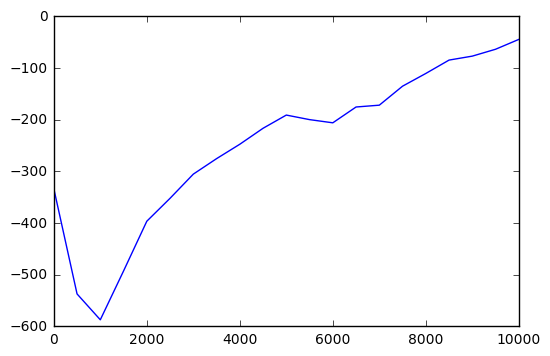

In [22]:
import pandas as pd
ticks,r = zip(*sorted(rewards.items(),key=lambda (k,v): k))
plt.plot(ticks,pd.ewma(np.array(map(np.mean,r)),alpha=0.1))

In [23]:
pool.evaluate(10)

[2016-12-20 04:07:55,854] Making new env: LunarLanderContinuous-v2
[2016-12-20 04:07:55,859] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-20 04:07:55,862] Starting new video recorder writing to /root/test/records/openaigym.video.20.1016402.video000000.mp4
[2016-12-20 04:07:58,927] Starting new video recorder writing to /root/test/records/openaigym.video.20.1016402.video000001.mp4


Episode finished after 139 timesteps with reward=-36.5259998925
Episode finished after 184 timesteps with reward=212.997228312
Episode finished after 287 timesteps with reward=246.746464263
Episode finished after 259 timesteps with reward=168.535138145
Episode finished after 216 timesteps with reward=225.27198281
Episode finished after 259 timesteps with reward=-132.168334701
Episode finished after 279 timesteps with reward=242.858432966


[2016-12-20 04:08:03,392] Starting new video recorder writing to /root/test/records/openaigym.video.20.1016402.video000008.mp4


Episode finished after 234 timesteps with reward=234.924650727


[2016-12-20 04:08:19,694] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/records')


Episode finished after 1000 timesteps with reward=-116.643797728
Episode finished after 90 timesteps with reward=-31.1345627066


[-36.525999892541137,
 212.99722831223886,
 246.74646426319785,
 168.53513814518595,
 225.27198280956736,
 -132.1683347009814,
 242.85843296613888,
 234.92465072652095,
 -116.64379772823617,
 -31.134562706638988]